# Tutorial 3. training WAC-Net to predict vertical positions

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/softmatterlab/Quantitative-Microplankton-Tracker/blob/main/training-tutorials/3-training_WACNet_vertical_positions.ipynb)

This tutorial demonstrates on how to train a WAC-Net (Weighted average convolutional neural network) for refining the predicted properties from RU-Net. It covers information on:

* Definining Simulation parameters
* Defining WAC-Net model using tensorflow keras
* Training WAC-Net model
* Testing the model on an experimental images 

<img src="https://raw.githubusercontent.com/softmatterlab/Quantitative-Microplankton-Tracker/main/assets/WAC-Net_z.png" alt="drawing" width="500"/>

**NOTE**:
- If you're running this notebook on your local machine, please comment the code in the cell below

In [8]:
!git clone https://github.com/softmatterlab/Quantitative-Microplankton-Tracker.git
%cd Quantitative-Microplankton-Tracker/training-tutorials/

In [9]:
%matplotlib inline
import sys
sys.path.append("..")

## 1. Setup
Import the dependencies to run this tutorial. 

In [10]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import deeptrack as dt

# Load exp data
predator_sequence = np.load(
    "../data/data_figure3/predator_sequence.npy"
)

prey_sequence = np.load(
    "../data/data_figure3/prey_sequence.npy"
)

coords_2d_predator = np.load(
    "../data/data_figure3/predator_2d_coords.npy"
)

coords_2d_prey = np.load(
    "../data/data_figure3/prey_2d_coords.npy"
)

## 2. Define training dataset

### 2.1. Define simulation parameters
We generate 15-frame sequences of simulated holgoraphic images to train the WAC-Net, where each image is of size 64 x 64 pixels.
Each image contains plankton holograms of different properties as defined below.

In [11]:
variables = {
    "pix_size": 3.6, # in micro meters
    "radius_range": [1.5e-6, 10e-6],
    "ri_range": [1.35, 1.38],
    "z_range": [2300, 3000], #in microns
    "apod_val": 0.07, #Gaussian apodization value
}

### 2.2. Define scatterrer properties
Each plankton is a scatterrer. 
We use the ```Sphere``` feature of DeepTrack to generate spherical scatterrers. 
Since we are using lensless-holographic setup, planktons can be approximated as spherical objects. 
All the other properties are automatically filled from the variables defined above in the cell above


#### 2.2.1. Define main plankton
The main plankton is the plankton that is always centered in a sequnce, and it is the plankton for which for which the dry mass and radius are predicted.

In [12]:
_sphere_main = dt.Sphere(
    position=(32, 32),
    position_unit="pixel",
    cam_pix_size=variables["pix_size"],
    radius=lambda: variables["radius_range"][0]
    + np.random.rand()
    * (variables["radius_range"][1] - variables["radius_range"][0]),
    refractive_index=lambda: variables["ri_range"][0]
    + np.random.rand() * (variables["ri_range"][1] - variables["ri_range"][0]),
    z=lambda: variables["z_range"][0] / variables["pix_size"]
    + np.random.rand()
    * (variables["z_range"][1] - variables["z_range"][0])
    / variables["pix_size"],
    find_me=True,
)


def get_position(previous_value):
    return previous_value + np.random.uniform(-1 / 8, 1 / 8, size=2)

sphere_main = dt.Sequential(_sphere_main, position=get_position)

#### 2.2.2 Define noise planktons
The noise planktons are planktons in the background

In [13]:
_sphere_noise = dt.Sphere(
    position=lambda: np.random.rand(2) * 64,
    position_unit="pixel",
    cam_pix_size=_sphere_main.cam_pix_size,
    z=_sphere_main.z,
    radius=_sphere_main.radius,
    refractive_index=_sphere_main.refractive_index,
    find_me=False,
)


def get_position2(previous_value):
    return previous_value + np.random.uniform(0, 7, size=2)


sphere_noise = dt.Sequential(_sphere_noise, position=get_position2)

### 2.3. Define the optical device
The scatterers are imaged with an optical device. We use the ```Brightfield``` feature of DeepTrack to define a microscope operating at ```wavelength``` of 633 nm.

In [14]:
optics = dt.Brightfield(
    wavelength=633e-9,
    NA=1,
    resolution=variables["pix_size"] * 1e-6,
    magnification=1,
    refractive_index_medium=1.33,
    apod_val=variables["apod_val"],
    upscale=4,
    aberration=lambda apod_val: dt.GaussianApodization(apod_val + np.random.uniform(-1,1)*0.01),
    output_region=(0, 0, 64, 64),
)

### 2.4. Define noises
We add gaussian noise to the generated images with a blur factor

In [15]:
from deeptrack.noises import Noise
from skimage.filters import gaussian
class Blurred_Gaussian(Noise):
    """Adds IID Gaussian noise to an image

    Parameters
    ----------
    mu : float
        The mean of the distribution.
    sigma : float
        The root of the variance of the distribution.
    """

    def __init__(self, mu=0, sigma=1,blur=2, **kwargs):
        super().__init__(mu=mu, sigma=sigma,blur=blur, **kwargs)

    def get(self, image, mu, sigma,blur, **kwargs):

        noisy_image = mu  + np.random.randn(*image.shape) * sigma
        noisy_image=gaussian(noisy_image,sigma=blur)
        noisy_image=image+noisy_image
        return noisy_image

noise = Blurred_Gaussian(mu=0, sigma= lambda: .025, blur=0.9+np.random.uniform(0,1)*0.1)

### 2.5. Define number of planktons (main and noise)
The main plankton is always set to 1, and number of noise planktons is set to vary between 0 to 3

In [16]:
sphere_main_no = lambda: np.random.randint(1, 2)
sphere_noise_no = lambda: np.random.randint(0, 3)

sample_normal = sphere_main ** sphere_main_no
sample_with_noise = sample_normal + sphere_noise ** sphere_noise_no

### 2.6. Combine all the properties defined above
Passing all the features to the optical device to generate sample sequences

In [17]:
image_formed = optics(sample_with_noise)

seq_length = 15
image_of_particles = dt.ConditionalSetFeature(
    on_true=dt.Sequence(image_formed, sequence_length=seq_length) + noise,
    on_false=dt.FlipUD(
        dt.FlipLR(
            dt.FlipDiagonal(
                dt.Sequence(image_formed, sequence_length=seq_length)
            )
        )
    )
    + noise,
    condition="skip_aug",
    skip_aug=False,
)

### 2.7. Visualize an example sequence

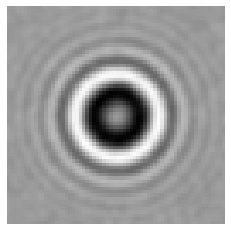

In [18]:
image_of_particles.update(skip_aug="False").plot(cmap="gray")

## 3. Creating target values

### 3.1. z-distance values
Function to generate normalized z values as outputs

In [19]:
def get_z(image):
    z = image[0].get_property("z")
    z = (z - variables["z_range"][0] / variables["pix_size"]) / (
        variables["z_range"][1] / variables["pix_size"]
        - variables["z_range"][0] / variables["pix_size"]
    )
    return z

## 4. Setup training
### 4.1. Define WAC-Net using keras

In [20]:
from tensorflow import keras

Sequential = keras.models.Sequential
Model = keras.models.Model
Dense = keras.layers.Dense
# Dropout = keras.layers.Dropout
Conv = keras.layers.Conv2D
Conv1D = keras.layers.Conv1D
ConvL = keras.layers.LocallyConnected2D
Pool = keras.layers.MaxPooling2D
Input = keras.layers.Input
Concat = keras.layers.Concatenate
TimeDistributed = keras.layers.TimeDistributed
Flatten = keras.layers.Flatten
Lambda = keras.layers.Lambda
K = keras.backend


model = Sequential()
model.add(
    (
        Conv(
            32,
            kernel_size=3,
            strides=1,
            activation="relu",
            input_shape=(64, 64, 1),
        )
    )
)
model.add(Pool(2))
model.add((Conv(64, kernel_size=3, strides=1, activation="relu")))
model.add(Pool(2))
model.add((Conv(128, kernel_size=3, strides=1, activation="relu")))
model.add(Pool(2))
model.add((Conv(256, kernel_size=3, strides=1, activation="relu")))
model.add((Flatten()))
model.add((Dense(128, activation="relu")))
model.add((Dense(128, activation="relu")))

stack = Input(model.input_shape)
vectors = TimeDistributed(model)(
    stack
)  # time distributed applies a layer to every temporal slice of the input
weights = Conv1D(128, 1, padding="same")(vectors)
weights = Conv1D(128, 1, padding="same")(weights)
weights = Conv1D(1, 1, padding="same")(weights)


def merge_function(tensors):
    x = tensors[0]
    weights = tensors[1]
    weights = K.softmax(weights, axis=1)
    merged = K.sum(x * weights, axis=1)
    return merged


merge_layer = Lambda(merge_function)

merged = merge_layer([vectors, weights])

merged = Dense(32, activation="relu")(merged)
merged = Dense(32, activation="relu")(merged)
out = Dense(1)(merged)
model = Model(stack, out)

model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 64, 64 0                                            
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, None, 128)    928768      input_1[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, None, 128)    16512       time_distributed[0][0]           
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, None, 128)    16512       conv1d[0][0]                     
_______________________________________________________________________________________

In [21]:
model.compile(tf.keras.optimizers.Adam(lr=0.0001, amsgrad=True), loss="mae")

### 4.2. Define batch function

In [22]:
def batch_function(image):
    for i in range(len(image)):
        image[i] = image[i] / np.median(image[i]) - 1
    return image

### 4.3. Define generator
The generator generates ```2000``` image sequences before the training begins, and continous to generate another ```2000``` sample sequences during the training process

In [23]:
generator = dt.generators.ContinuousGenerator(
    image_of_particles,
    get_z,
    batch_size=64,
    batch_function=batch_function,
    min_data_size=2000,
    max_data_size=4000,
    ndim=5,
)

## 5. Train the model
Set the ```TRAIN_MODEL``` = ```True``` to train the model from scratch.
Set the ```TRAIN_MODEL``` = ```False``` to load a pretrained model.

In [24]:
TRAIN_MODEL = False

### 5.1. Generating validation data
Skip this step if would not like to generate validation data

In [25]:
if TRAIN_MODEL:

    print("Generating validation data...")
    b = []
    l = []
    for i in tqdm(range(1000)):
        im = image_of_particles.update(skip_aug=False).resolve()
        b.append(batch_function(im))
        l.append(get_z(im))
    b = np.array(b)
    l = np.array(l)

### 5.2. Start the training
Set the ```TRAIN_MODEL``` to True to train the network from scratch

In [26]:
if TRAIN_MODEL:
    
    with generator:
        history = model.fit(
            generator, epochs=1000, steps_per_epoch=16, validation_data=(b, l)
        )

else:
    model.load_weights("../pre-trained-models/WACNet_vertical_positions.h5")

## 6. Testing the trained model on experimental sequences
### 6.1. Normalise the experimental images
Functions normalise the images, and to convert predicted dry mass values to real values

In [27]:
def Normalise(images, batch = 15):
    Normalised = []
    for i in range(len(images)):
        Normalised.append(images[i]/np.median(images[i]))
    Normalised = np.array(Normalised)-1
    proc = []
    
    #sliding window
    for i in range(len(Normalised)-batch+1):
        proc.append(Normalised[i:i+batch])
    return np.expand_dims(proc, axis = -1)

In [28]:
def real_z(p, a=700, b=2300):
    return (p*a+b)

### 6.2. Check predictions

In [29]:
prediction_predator = model.predict(
    Normalise(
        predator_sequence,
        batch = 1
    )
)

prediction_prey = model.predict(
    Normalise(
        prey_sequence,
        batch = 1
    )
)

In [30]:
z_predator = real_z(prediction_predator[:,0])
z_prey = real_z(prediction_prey[:,0])

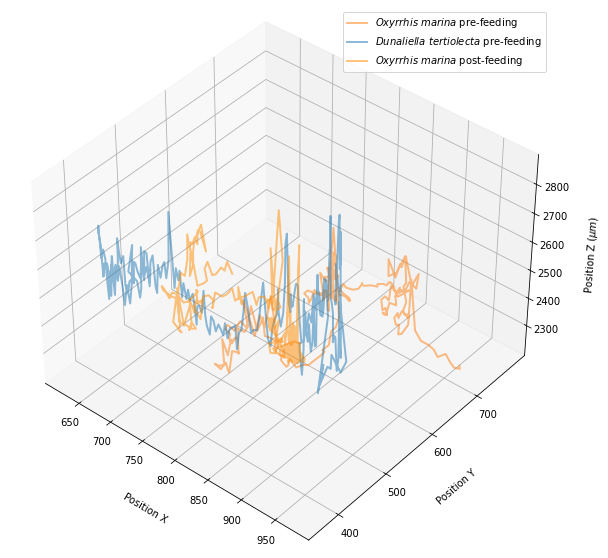

In [31]:
feeding_at = 219

fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')


ax.plot(coords_2d_predator[:,0][:feeding_at], coords_2d_predator[:,1][:feeding_at], z_predator[:feeding_at], label='$\it{Oxyrrhis\ marina}$ pre-feeding',
        color="tab:orange", alpha=0.5, linestyle="solid", linewidth=2)

ax.plot(coords_2d_prey[:,0][:feeding_at], coords_2d_prey[:,1][:feeding_at], z_prey[:feeding_at], label='$\it{Dunaliella\ tertiolecta}$ pre-feeding',
        color="tab:blue", alpha=0.5, linestyle="solid", linewidth=2)

ax.plot(coords_2d_predator[:,0][feeding_at:], coords_2d_predator[:,1][feeding_at:], z_predator[feeding_at:], label='$\it{Oxyrrhis\ marina}$ post-feeding',
        color="darkorange", alpha=0.5, linestyle="solid", linewidth=2)

plt.legend()

ax.set_xlabel('\n\n\n Position X')
ax.set_ylabel('\n\n\n Position Y')
ax.set_zlabel('\n\n\n Position Z ($\mu m$)')

ax.azim = -50
ax.elev = 40
ax.dist = 10

plt.show()